# The Sequencing Process: Obtaining Pulse Instances From Pulse Templates

In the previous examples, we have modelled pulses using the basic members of qctoolkit's `PulseTemplate` class hierarchy. However, these are only templates (or classes) of pulses and may contain parameters so that they cannot be run directly on hardware. First, we have to instantiate concrete waveforms and instructions in which order these will be run. This process is called _sequencing_ in the qctoolkit. It involves the instantiations of parameters with concrete values and the sampling of atomic pulse templates (`TablePulseTemplate` and `FunctionPulseTemplate`) to obtain waveforms. _Sequencing_ is performed by the `Sequencer` class. This example will explore how.

First, let's assume we have the `PulseTemplate`s from the examples [Modelling a Simple TablePulseTemplate](00SimpleTablePulse.ipynb) and [Modelling Pulses Using Functions And Expressions](02FunctionPulse.ipynb) composed in a `SequencePulseTable` (cf. [Combining PulseTemplates Using SequencePulseTemplate](01SequencePulse.ipynb)) with some parameter mappings:

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


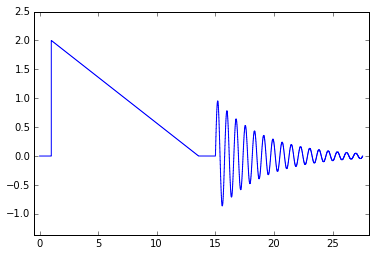

In [5]:
%matplotlib inline
from qctoolkit.pulses import TablePulseTemplate, FunctionPulseTemplate, SequencePulseTemplate, plot

table_template = TablePulseTemplate()
table_template.add_entry('ta', 'va', interpolation='hold')
table_template.add_entry('tb', 'vb', interpolation='linear')
table_template.add_entry('tend', 0, interpolation='jump')

function_template = FunctionPulseTemplate('exp(-t/lambda)*sin(phi*t)', 'duration')

table_parameter_mapping = {
    'ta': 'ta',
    'tb': 'ta + duration',
    'tend': '15',
    'va': 'va',
    'vb': '0'
}
function_parameter_mapping = {
    'lambda': 'lambda',
    'phi': 'phi',
    'duration': 'duration'
}
sequence_template = SequencePulseTemplate([(table_template, table_parameter_mapping),
                                           (function_template, function_parameter_mapping)],
                                          {'ta', 'duration', 'va', 'lambda', 'phi'})


plot(sequence_template, {'lambda': 4, 'phi': 8, 'duration': 4*3.1415, 'ta': 1, 'va': 2}, sample_rate=100)

While the plot illustrates how the pulse will look like for the given parameter values, the object structure we created is only an abstract representation of pulses with this structure. (This is the reason we always have to provide specific parameters values for plotting.)
To convert this tree-like object structure into something the hardware understands, we will use the `Sequencer` class:

In [7]:
from qctoolkit.pulses import Sequencer

sequencer = Sequencer()

sequencer.push(sequence_template, {'lambda': 4, 'phi': 8, 'duration': 4*3.1415, 'ta': 1, 'va': 2})
instruction_sequence = sequencer.build()
print(instruction_sequence)

[<qctoolkit.pulses.instructions.EXECInstruction object at 0x000000000734FEF0>, <qctoolkit.pulses.instructions.EXECInstruction object at 0x00000000072E3E48>, <qctoolkit.pulses.instructions.STOPInstruction object at 0x00000000072E3E10>]


Using the `push` method of `Sequencer`, we add `PulseTemplate` objects to the sequencing stack, i.e., the last pushed object will be sequenced first. We then invoke the `build` method to start the sequencing process, which will process all objects on the stack and return a sequence of hardware instructions. As you can see in the output of the above code snippet, the `Sequencer` created a sequence of two `EXECInstruction`s and a `STOPInstruction`. The two `EXECInstruction`s refer to waveforms obtained by sampling the atomic template objects `table_template` and `function_template` of which the `sequence_template` we've sequenced is composed.

These waveforms are represented by objects of the `Waveform` class, which exposes a method `sample`, accepting an array of sample points in the time domain and returning an equally long array of sample values. The choice of the sample points passed into the `sample` method together with the sample rate of the playback device determine the duration of a time unit in a pulse template. For example, a pulse template with a length of 1 time unit that is sampled using 1000 equidistant sample points will play for 1 µs on a playback device with a sample rate of 1 GHz.

After the sequencing process is complete, the instruction sequence will be passed to a hardware-dependent interpreter which will configure the corresponding device accordingly and perform the sampling of the waveform depending on the device's sample rate and typically a parameter indicating the real-time duration of a pulse template time unit.



Note that the `plot` function internally employs sequencing and then simply plots the generated waveforms.

## Side Note: Instructions

The generated instruction sequence will consist of some of the following instructions:
- EXECInstruction: execute a waveform
- STOPInstruction: stop the execution
- JUMPInstruction: jump to some instruction in the instruction sequence based on some trigger/condition
- GOTOInstruction: go to some instruction in the instruction sequence

The latter two will only be generated when hardware-based conditional branching is used in `LoopPulseTemplate` and `BranchPulseTemplate`. This was the main motivator for the usage of such an instruction sequence rather than just compling one large waveform.
Using only the `PulseTemplate`s discussed so far, only `EXECInstruction`s and a final `STOPInstruction` will be output by the `Sequencer`.